## Rúbrica para evaluación de 3er parcial
Se evaluará:

Que el script no contenga errores

Que los resultados del script sean reproducibles, ie que puedan ser reproducibles en cualquier computadora

El orden del código

La lógica del código

La inferencia empleada para los parámetros utilizados, tales como thresholds para filtrado de matriz, elección de thresholds para selección de alguna banda específica (alfa, beta, delta, etc.)

Los métodos utilizados, ie, si para construir la matriz de conectividad se utilizó coherencia espectral, PLV o correlación, que haya una razón de ello

Los resultados mostrados, tales como mapas de calor, grafos 2D, grafos 3D, el mostrar comunidades, hubs, nodos proporcionales al grado, filtrado de matriz

Conclusión del análisis, ie, al finalizar el análisis dar una conclusión que resuma los resultados encontrados con una interpretación de los mismos

Que el análisis haya sido aplicado a cada uno de los ensayos/archivos del dataset

In [45]:
import numpy as np
import openpyxl
import pandas as pd
import networkx as nx

import seaborn as sns
from IPython.core.pylabtools import figsize
from scipy import stats
import matplotlib.pyplot as plt

#from S02_clases.notas.metrics_per_graph import path_length, small_world_sigma, betweenness

In [81]:

from mi_modulo import *

In [46]:
ensayo3= pd.read_excel("E:\modelos\eeg-motor-movementimagery_Ensayo_03.xlsx", sheet_name=None, index_col=0)
ensayo4= pd.read_excel("E:\modelos\eeg-motor-movementimagery_Ensayo_04.xlsx", sheet_name=None, index_col=0)

myCoor=pd.read_csv("E:\modelos\MI_coordinates.csv")


In [47]:
ensayos3_dfs=[]
for sujeto in ensayo3.keys():
    ensayos3_dfs.append(ensayo3[sujeto])

In [48]:
ensayos4_dfs=[]
for sujeto in ensayo4.keys():
    ensayos4_dfs.append(ensayo4[sujeto])

In [50]:
ensayos3_dfs[108]
# solo para comprobar que si se cargaron bien

Fc5.      Fc3.      Fc1.      Fcz.      Fc2.      Fc4.      Fc6.  \
Fc5.  0.000000  0.030143  0.009105  0.026979  0.028951  0.009172  0.022373   
Fc3.  0.030143  0.000000  0.138800  0.593874  0.492735  0.035314  0.291651   
Fc1.  0.009105  0.138800  0.000000  0.159232  0.138557  0.018189  0.083433   
Fcz.  0.026979  0.593874  0.159232  0.000000  0.830225  0.064798  0.462565   
Fc2.  0.028951  0.492735  0.138557  0.830225  0.000000  0.087842  0.582870   
...        ...       ...       ...       ...       ...       ...       ...   
Po8.  0.015091  0.101920  0.031263  0.147167  0.150385  0.007535  0.156253   
O1..  0.012627  0.149074  0.039548  0.159803  0.147472  0.009954  0.110983   
Oz..  0.016105  0.124599  0.033106  0.147223  0.141755  0.009704  0.110344   
O2..  0.015195  0.098749  0.025520  0.125607  0.122040  0.006595  0.113725   
Iz..  0.015949  0.098562  0.028215  0.115984  0.113328  0.009390  0.094469   

          C5..      C3..      C1..  ...      P8..      Po7.      Po3.  \
Fc5.  0.027457  0.033296  0.020123  ...  0.015549  0.013393  0.017215   
Fc3.  0.517274  0.685112  0.426557  ...  0.102761  0.200895  0.276360   
Fc1.  0.100466  0.149731  0.107751  ...  0.033804  0.049389  0.069393   
Fcz.  0.428087  0.655909  0.500526  ...  0.160388  0.192819  0.302113   
Fc2.  0.358318  0.546724  0.422095  ...  0.177724  0.164178  0.269109   
...        ...       ...       ...  ...       ...       ...       ...   
Po8.  0.135153  0.165926  0.092765  ...  0.798737  0.236946  0.330104   
O1..  0.258997  0.281184  0.141234  ...  0.228816  0.809415  0.822152   
Oz..  0.191783  0.224338  0.122201  ...  0.278487  0.542675  0.665015   
O2..  0.145650  0.173306  0.092265  ...  0.496682  0.352731  0.472841   
Iz..  0.182660  0.184921  0.079661  ...  0.352896  0.563253  0.557574   

          Poz.      Po4.      Po8.      O1..      Oz..      O2..      Iz..  
Fc5.  0.019006  0.018033  0.015091  0.012627  0.016105  0.015195  0.015949  
Fc3.  0.245635  0.172925  0.101920  0.149074  0.124599  0.098749  0.098562  
Fc1.  0.063891  0.047492  0.031263  0.039548  0.033106  0.025520  0.028215  
Fcz.  0.307180  0.247762  0.147167  0.159803  0.147223  0.125607  0.115984  
Fc2.  0.292179  0.246807  0.150385  0.147472  0.141755  0.122040  0.113328  
...        ...       ...       ...       ...       ...       ...       ...  
Po8.  0.446316  0.792164  0.000000  0.345933  0.448859  0.723286  0.527310  
O1..  0.697596  0.505815  0.345933  0.000000  0.793124  0.550609  0.728469  
Oz..  0.779857  0.652900  0.448859  0.793124  0.000000  0.764746  0.780450  
O2..  0.624942  0.786841  0.723286  0.550609  0.764746  0.000000  0.734696  
Iz..  0.583357  0.598427  0.527310  0.728469  0.780450  0.734696  0.000000  

[64 rows x 64 columns]

## Filtrado de matrices
conjuntar las 109 matrices en una, con un stack

In [51]:
threshold=0.5
porcentaje=0.6

def capsula (lista_dfs, th, porcentaje_):
    # Conjuntar matrices
    stack=np.stack([df.values for df in lista_dfs])
    above=stack > th

    # aplicar filtro a matriz
    N=len(lista_dfs)
    count_above=above.sum(axis=0) #contabilizar cuantos valores superan umbral en la celda

    min_requerido=int(np.ceil(porcentaje_*N)) #con esto nos quedamos cocn las celdas de above que cumplan con min_requerido para así tener el número de sujetos que superan el umbral => MATRIZ BINARIZADA

    result_bool= count_above>= min_requerido

    result_df= pd.DataFrame(result_bool, index=lista_dfs[0].index, columns=lista_dfs[0].columns).astype(int)
    return result_df

resultado3_df=capsula(ensayos3_dfs,0.5,0.6)
resultado4_df=capsula(ensayos4_dfs,0.5,0.6)

## Generar estaditicos para decidir umbral

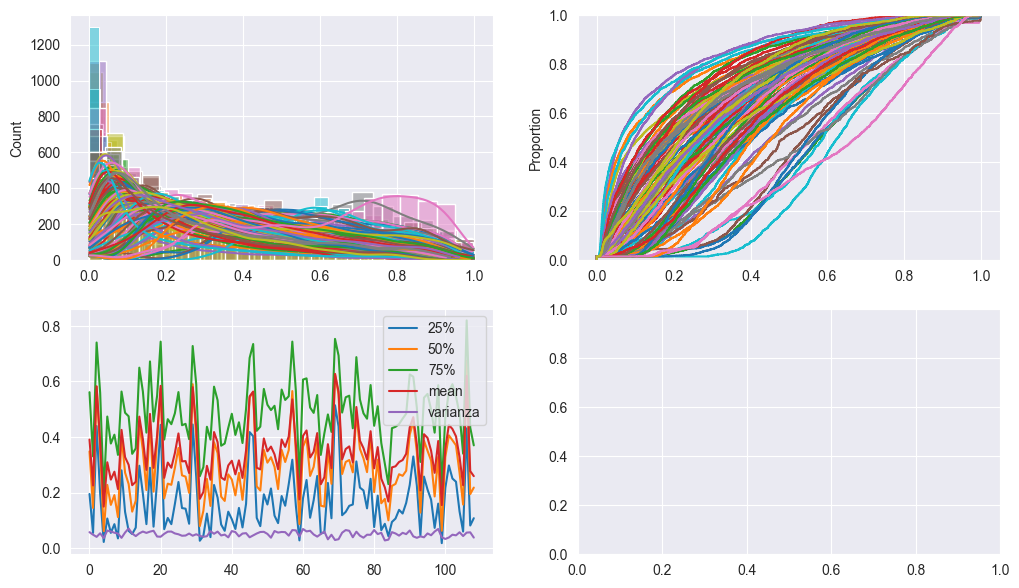

In [52]:
th25, th50, th75, promedio, varianza, mu_sigma= [],[],[],[],[], []

fig, axes= plt.subplots(2,2,figsize=[12,7])
for sujeto in ensayos3_dfs:
    data=sujeto.stack().values
    th25.append(np.percentile(data,25))
    th50.append(np.percentile(data,50))
    th75.append(np.percentile(data,75))
    promedio.append(np.mean(data))
    varianza.append(np.var(data))
    mu_sigma.append(np.mean(data)+np.var(data))

    # Plots
    sns.histplot(sujeto.stack().values, ax=axes[0,0], kde=True) #kde suaviza histograma
    sns.ecdfplot(sujeto.stack().values, ax=axes[0,1])

axes[1][0].plot(th25,label="25%")
axes[1][0].plot(th50,label="50%")
axes[1][0].plot(th75,label="75%")
axes[1][0].plot(promedio,label="mean")
axes[1][0].plot(varianza,label="varianza")
axes[1][0].legend()


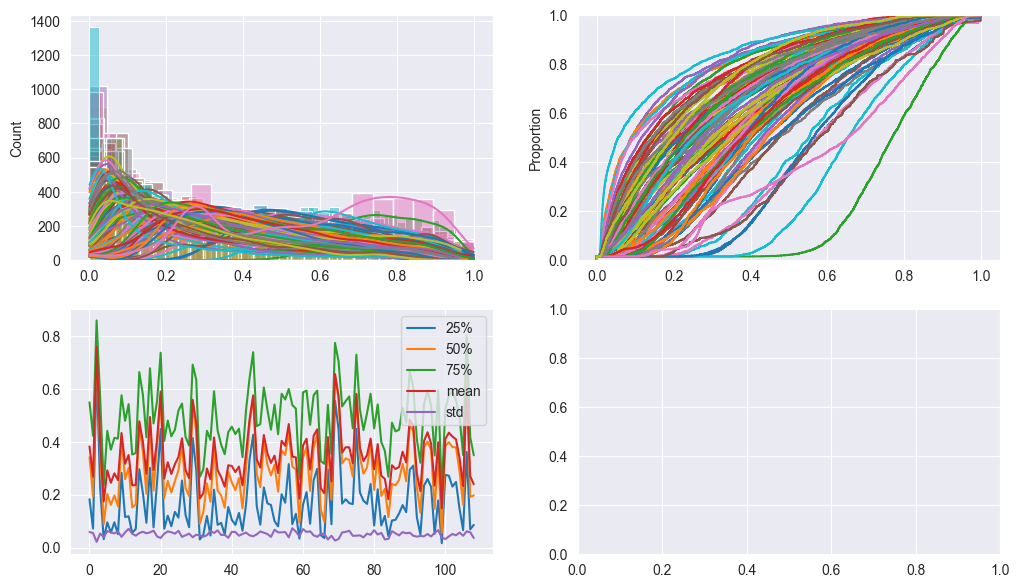

In [54]:
th25_e4, th50_e4, th75_e4, promedio_e4, varianza_e4, mu_sigma_e4= [],[],[],[],[], []

fig, axes= plt.subplots(2,2,figsize=[12,7])
for sujeto in ensayos4_dfs:
    data_e4=sujeto.stack().values
    th25_e4.append(np.percentile(data_e4,25))
    th50_e4.append(np.percentile(data_e4,50))
    th75_e4.append(np.percentile(data_e4,75))
    promedio_e4.append(np.mean(data_e4))
    varianza_e4.append(np.var(data_e4))
    mu_sigma_e4.append(np.mean(data_e4)+np.var(data_e4))

    # Plots
    sns.histplot(sujeto.stack().values, ax=axes[0,0], kde=True) #kde suaviza histograma
    sns.ecdfplot(sujeto.stack().values, ax=axes[0,1])

axes[1][0].plot(th25_e4,label="25%")
axes[1][0].plot(th50_e4,label="50%")
axes[1][0].plot(th75_e4,label="75%")
axes[1][0].plot(promedio_e4,label="mean")
axes[1][0].plot(varianza_e4,label="std")
axes[1][0].legend()

In [56]:
stats.median_abs_deviation(th25)

np.float64(0.06955915283857339)

In [60]:
estadisticosE3_df=pd.DataFrame(columns=['th25','th50','th75','promedio','mu_sigma'],index=['min','max','mediana','mu_sigma']);
columnas=[ th25, th50, th75, promedio, mu_sigma]
for i in range(len(columnas)):
    estadisticosE3_df.iloc[0,i]= np.min(columnas[i])
    estadisticosE3_df.iloc[1,i]= np.max(columnas[i])
    estadisticosE3_df.iloc[2,i]= np.median(columnas[i])
    estadisticosE3_df.iloc[3,i]= np.mean(columnas[i])

estadisticosE3_df

th25      th50      th75  promedio  mu_sigma
min       0.018413   0.06175  0.196867  0.149821  0.186222
max       0.514472  0.674805  0.819681  0.626848  0.676548
mediana   0.144574  0.273808  0.484181    0.3277  0.389466
mu_sigma  0.166961  0.295352  0.489628  0.345504   0.39634

In [62]:
estadisticosE4_df=pd.DataFrame(columns=['th25','th50','th75','promedio','mu_sigma'],index=['min','max','mediana','mu_sigma']);
columnas=[ th25_e4, th50_e4, th75_e4, promedio_e4, mu_sigma_e4]
for i in range(len(columnas)):
    estadisticosE4_df.iloc[0,i]= np.min(columnas[i])
    estadisticosE4_df.iloc[1,i]= np.max(columnas[i])
    estadisticosE4_df.iloc[2,i]= np.median(columnas[i])
    estadisticosE4_df.iloc[3,i]= np.mean(columnas[i])

estadisticosE4_df

th25      th50      th75  promedio  mu_sigma
min       0.016915  0.055561  0.210152  0.148728  0.186648
max        0.68082  0.768026  0.859416  0.758803  0.780441
mediana   0.135265  0.288254  0.480688  0.333706  0.384217
mu_sigma  0.171176  0.300271  0.495304  0.350497  0.401371

### Propuesta de umbrales, mandar a llamar una sola función que contenga toda la info
#### vamos a encapusar toda un alinea de codigo en una sola, que variables vamos a querer cambiar

In [64]:
from scipy.stats import median_abs_deviation

Text(0.5, 0.98, 'Análisis estadísticos en ensayo 3')

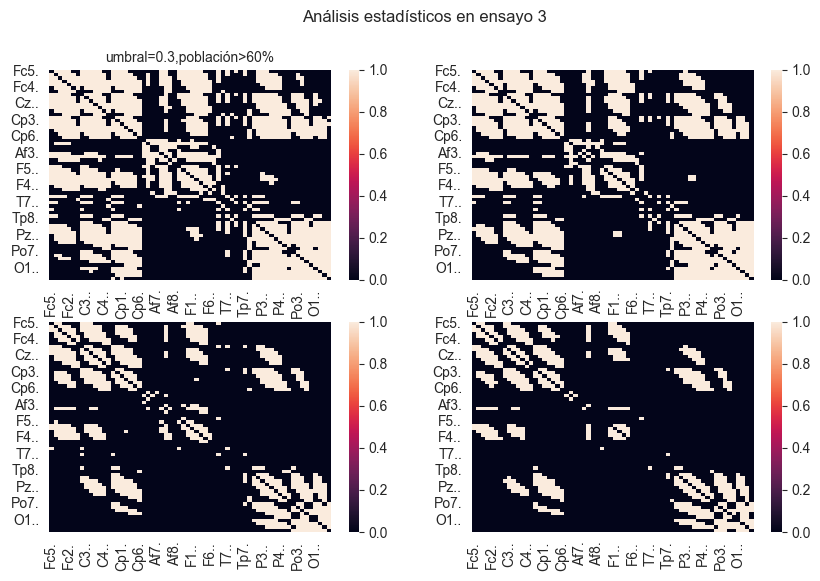

In [65]:
resultadosE3_df1=capsula(ensayos3_dfs,0.3,0.6)
resultadosE3_df2=capsula(ensayos3_dfs,0.3,0.7)
resultadosE3_df3=capsula(ensayos3_dfs,0.5,0.6)
resultadosE3_df4=capsula(ensayos3_dfs,0.5,0.7)

fig,axes=plt.subplots(2,2,figsize=[10,6])
sns.heatmap(resultadosE3_df1,ax=axes[0,0])
sns.heatmap(resultadosE3_df2,ax=axes[0,1])
sns.heatmap(resultadosE3_df3,ax=axes[1,0])
sns.heatmap(resultadosE3_df4,ax=axes[1,1])

axes[0,0].set_title("umbral=0.3,población>60%", fontsize=10 )
fig.suptitle('Análisis estadísticos en ensayo 3')

Text(0.5, 0.98, 'Analisis estadísticos en ensayo 4')

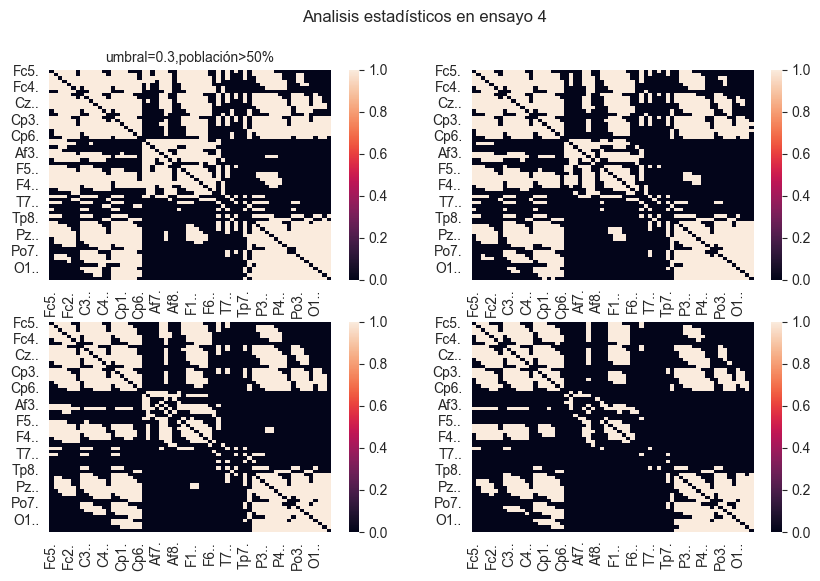

In [67]:
resultadosE4_df1=capsula(ensayos4_dfs,0.3,0.5)
resultadosE4_df2=capsula(ensayos4_dfs,0.3,0.6)
resultadosE4_df3=capsula(ensayos4_dfs,0.3,0.7)
resultadosE4_df4=capsula(ensayos4_dfs,0.3,0.8)

fig,axes=plt.subplots(2,2,figsize=[10,6])
sns.heatmap(resultadosE4_df1,ax=axes[0,0])
sns.heatmap(resultadosE4_df2,ax=axes[0,1])
sns.heatmap(resultadosE4_df3,ax=axes[1,0])
sns.heatmap(resultadosE4_df4,ax=axes[1,1])

axes[0,0].set_title("umbral=0.3,población>50%", fontsize=10 )
fig.suptitle('Analisis estadísticos en ensayo 4')

## Generacion de resultados
### despues del analisis realizados, para poder escoger un umbral adecuado y un porcentaje de la poblacion que cumpla dicho umbral

resultados a generar
- Grafo 2d
- grafo 3d
- metricas del grafo
- gráfico de comunidades con hub

In [25]:
def grafo2D(df):
    ensayo_grafo=nx.from_pandas_adjacency(df)
    nx.draw_circular(ensayo_grafo, with_labels=True)

    return ensayo_grafo

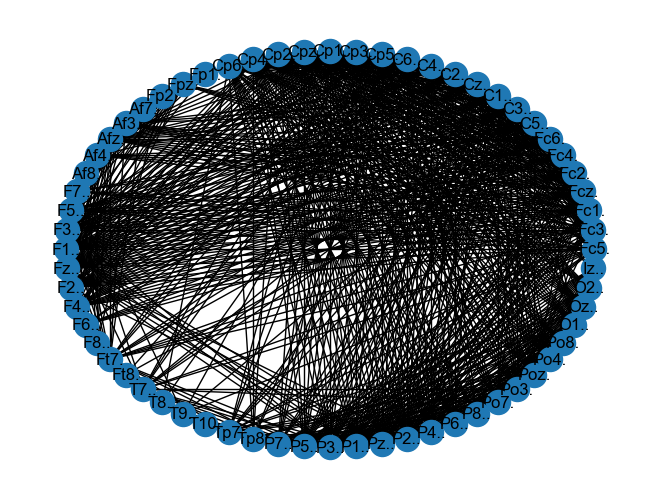

In [68]:
ensayo3_grafo=grafo2D(resultadosE3_df1)

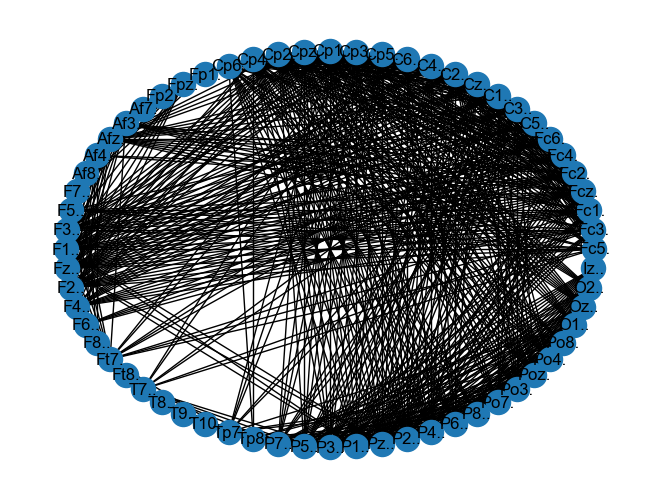

In [70]:
ensayo4_grafo=grafo2D(resultadosE4_df3)

In [73]:
def metricas_grafo(G):
    #Metricas:
    # Cluster promedio
    clust_coeff= nx.average_clustering(G)
    # Longitud de camino promedio(camino más corto)
    # (b) Longitud de camino promedio (camino más corto)
    try:
        path_length = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        path_length = np.nan  # red no conexa
    # Mundo pequeño
    # Comparar con grafo aleaatorio de igual N,K
    G_rand=nx.gnm_random_graph(n=G.number_of_nodes(), m=G.number_of_edges())
    clust_rand= nx.average_clustering(G_rand)
    path_rand= nx.average_shortest_path_length(G_rand)
    small_world_sigma= (clust_coeff/clust_rand)/(path_length/path_rand)
    #Modularidad
    # (d) Modularidad — usando método de comunidades
    from networkx.algorithms import community
    communities = community.greedy_modularity_communities(G)
    modularity = community.modularity(G, communities)

    # (e) Hubs — grado, centralidad de intermediación
    degree_dict = dict(G.degree())
    betweenness = nx.betweenness_centrality(G)
    betwenness= sorted(betweenness.items(),key=lambda x: x[1],reverse=True)

    # (f) Eficiencia global y local
    global_eff = nx.global_efficiency(G)
    local_eff = nx.local_efficiency(G)

    return (clust_coeff, path_length,small_world_sigma,communities,modularity,betwenness,global_eff,local_eff,degree_dict)

In [74]:
(clust_coeffE3, path_lengthE3,small_world_sigmaE3,communitiesE3,modularityE3,betwennessE3,global_effE3,local_effE3,degree_dictE3)=metricas_grafo(ensayo3_grafo)

In [75]:
(clust_coeffE4, path_lengthE4,small_world_sigmaE4,communitiesE4,modularityE4,betwennessE4,global_effE4,local_effE4,degree_dictE4)=metricas_grafo(ensayo4_grafo)

In [76]:
myCoor.set_index('canal', drop=True ,inplace=True)

In [77]:
myCoor.loc['Fc5.','y']

np.float64(0.2666)

In [85]:
def grafo_comunidades(comunidades, Hub, coords, pos):
    x, y, z = coords["x"].values, coords["y"].values, coords["z"].values

    nodes_size = [30 if idx != Hub[0] else 200 for idx in coords.index] # cambiar el tamaño del nodo si es el hub
    pos.scatter(x, y, z, alpha = 0.5)

    for idx, (x_, y_, z_) in enumerate(zip(x, y, z)):
        pos.text(x_, y_, z_, coords.index[idx], fontsize = 10)
        if coords.index[idx] == Hub[0]:
            pos.text(x_, y_, z_, "HUB", color = "red", fontsize = 13) # cambiar el color del texto del nodo si es el hub

    colores = ["yellow", "blue", "orange", "olive", "red"]
    for n_comunidad, comunidad in enumerate(comunidades):  # recorrer las comunidades, plotearemos así las aristas
        for idx in range(len(comunidad)-1):
            n1, n2 = list(comunidad)[idx], list(comunidad)[idx+1]
            # plotear arista
            x_ = [coords.loc[n1, "x"], coords.loc[n2, "x"]]
            y_ = [coords.loc[n1, "y"], coords.loc[n2, "y"]]
            z_ = [coords.loc[n1, "z"], coords.loc[n2, "z"]]
            pos.plot(x_, y_, z_, linewidth = 3, alpha = 0.4, color = colores[n_comunidad])

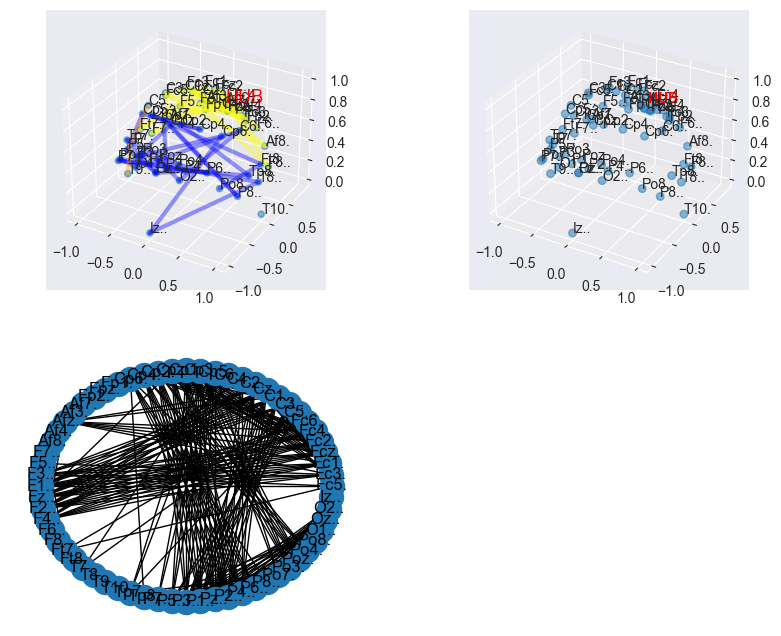

In [86]:
hub = betwennessE3[0]

fig = plt.figure(figsize=(10, 8))
axes = [fig.add_subplot(2, 2, 1, projection='3d'),
        fig.add_subplot(2,2,2, projection='3d'),
        fig.add_subplot(2,2,3)]

grafo_comunidades(communitiesE3, hub, myCoor, axes[0])
grafo3D(myCoor, hub, axes[1])
ensayo3_grafo= grafo2D(resultadosE3_df3, axes[2])

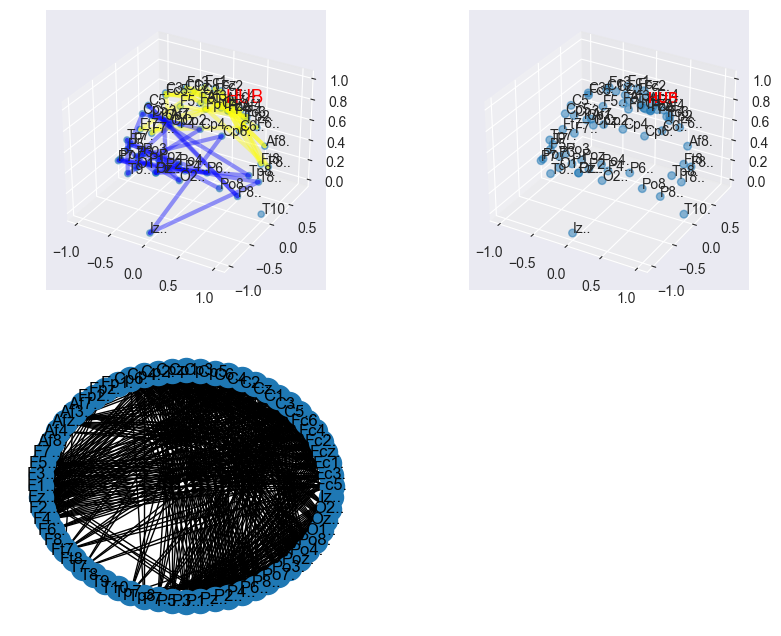

In [87]:
hub = betwennessE4[0]

fig = plt.figure(figsize=(10, 8))
axes = [fig.add_subplot(2, 2, 1, projection='3d'),
        fig.add_subplot(2,2,2, projection='3d'),
        fig.add_subplot(2,2,3)]

grafo_comunidades(communitiesE4, hub, myCoor, axes[0])
grafo3D(myCoor, hub, axes[1])
ensayo4_grafo= grafo2D(resultadosE4_df3, axes[2])

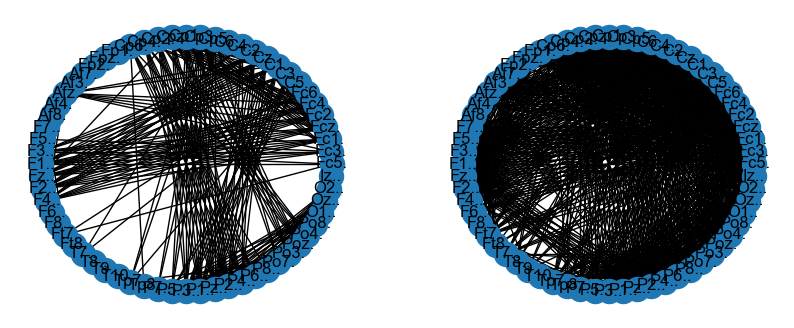

In [88]:
#  Grafo circular
hub3= betwennessE3
hub4= betwennessE4

fig= plt.figure(figsize=(10,4))
axes=[fig.add_subplot(1,2,1),
      fig.add_subplot(1,2,2)]

ensayo_grafo= grafo2D(resultadosE3_df3, axes[0])
ensayo_grafo= grafo2D(resultadosE4_df1,axes[1])

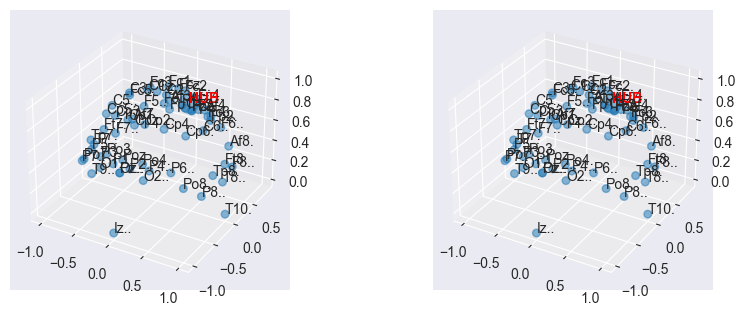

In [89]:
hub3= betwennessE3[0]
hub4= betwennessE4[0]

fig = plt.figure(figsize=(10, 8))
axes = [fig.add_subplot(2, 2, 1, projection='3d'),
        fig.add_subplot(2, 2, 2, projection='3d')]

grafo3D(myCoor, hub3, axes[0])
grafo3D(myCoor, hub4, axes[1])

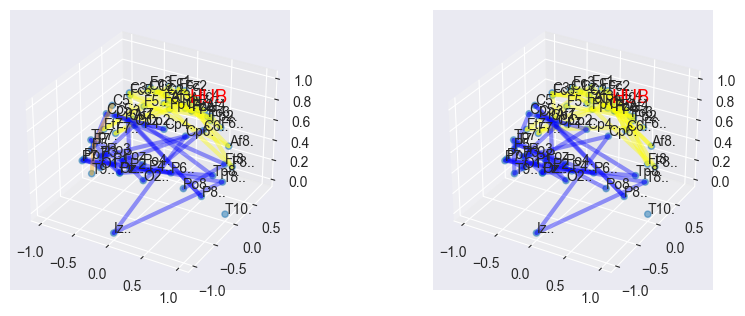

In [90]:
fig = plt.figure(figsize=(10, 8))
axes = [fig.add_subplot(2, 2, 1, projection='3d'),
        fig.add_subplot(2, 2, 2, projection='3d')]

grafo_comunidades(communitiesE3, hub3, myCoor, axes[0])
grafo_comunidades(communitiesE4, hub4, myCoor, axes[1])

# Ensayos 5 y 6

In [91]:
ensayo5= pd.read_excel("E:\modelos\eeg-motor-movementimagery_Ensayo_05.xlsx", sheet_name=None, index_col=0)
ensayo6= pd.read_excel("E:\modelos\eeg-motor-movementimagery_Ensayo_06.xlsx", sheet_name=None, index_col=0)

In [92]:
ensayos5_dfs=lista_dfs(ensayo5)
ensayos6_dfs=lista_dfs(ensayo6)

In [93]:
resultado5_df=capsula(ensayos5_dfs,0.5,0.6)
resultados6_df= capsula(ensayos6_dfs,0.4,0.7)

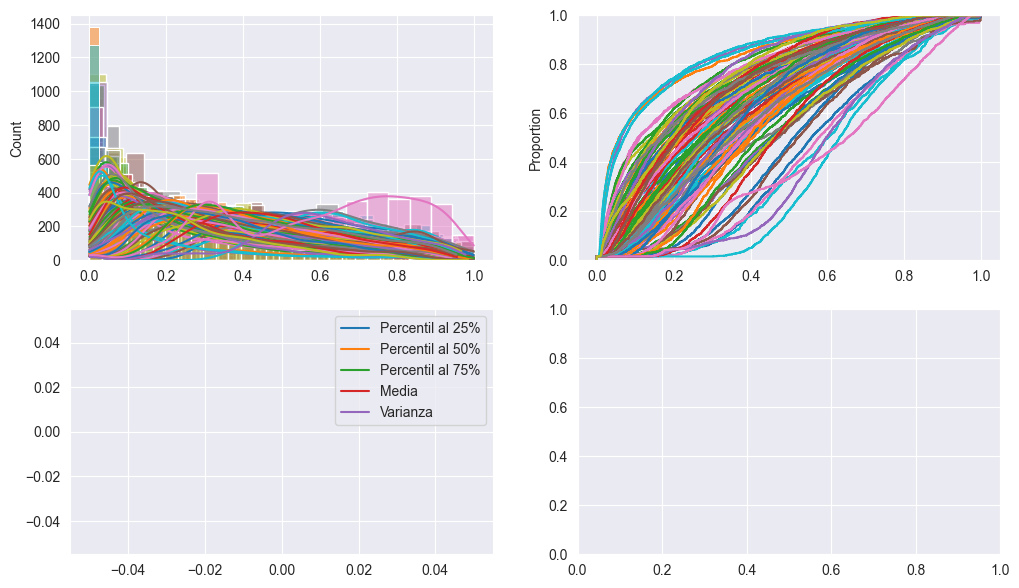

In [94]:
ensayos_dfs = ensayos5_dfs

th25_E5, th50_E5, th75_E5, promedio_E5, varianza_E5 = [], [], [], [], []
mu_sigma = []

fig, axes = plt.subplots(2,2, figsize=(12,7))


for sujeto in ensayos_dfs:
    # cálculo estadísticos
    data = sujeto.stack().values
    th25.append(np.percentile(data, 25))
    th50.append(np.percentile(data, 50))
    th75.append(np.percentile(data, 75))
    promedio.append(np.mean(data))
    varianza.append(np.var(data))
    mu_sigma.append(np.mean(data) + np.var(data))

    # plots
    sns.histplot(sujeto.stack().values, ax=axes[0][0], kde=True)  # kde=True --> para mostrar la distribución suavizada
    sns.ecdfplot(sujeto.stack().values, ax=axes[0][1])
axes[1][0].plot(th25_E5, label="Percentil al 25%")
axes[1][0].plot(th50_E5, label="Percentil al 50%")
axes[1][0].plot(th75_E5, label="Percentil al 75%")
axes[1][0].plot(promedio_E5, label="Media")
axes[1][0].plot(varianza_E5, label="Varianza")
axes[1][0].legend()

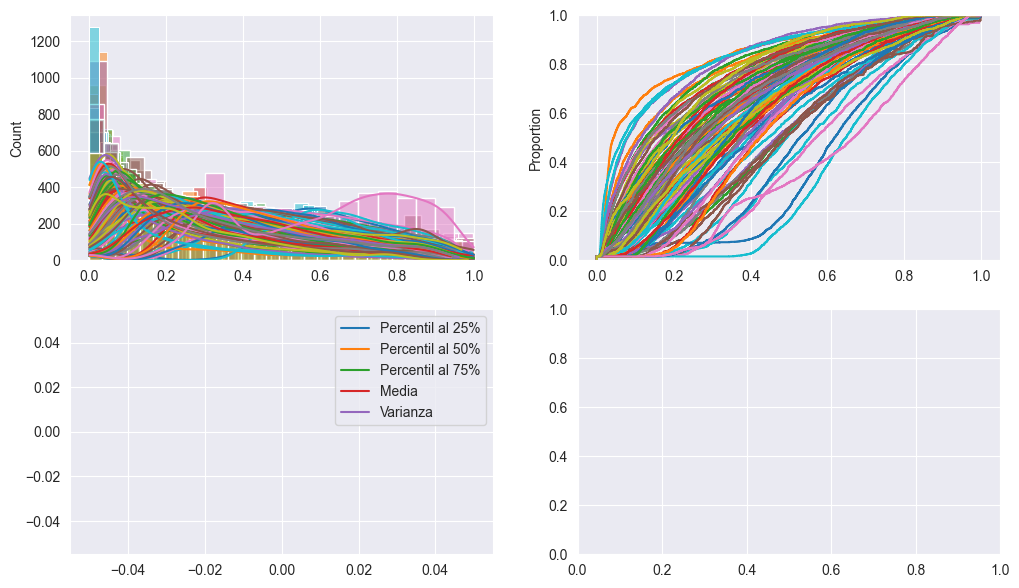

In [95]:
ensayos_dfs = ensayos6_dfs

th25_E6, th50_E6, th75_E6, promedio_E6, varianza_E6 = [], [], [], [], []
mu_sigma = []

fig, axes = plt.subplots(2, 2, figsize=(12, 7))

for sujeto in ensayos_dfs:
    # cálculo estadísticos
    data = sujeto.stack().values
    th25.append(np.percentile(data, 25))
    th50.append(np.percentile(data, 50))
    th75.append(np.percentile(data, 75))
    promedio.append(np.mean(data))
    varianza.append(np.var(data))
    mu_sigma.append(np.mean(data) + np.var(data))

    # plots
    sns.histplot(sujeto.stack().values, ax=axes[0][0], kde=True)  # kde=True --> para mostrar la distribución suavizada
    sns.ecdfplot(sujeto.stack().values, ax=axes[0][1])
axes[1][0].plot(th25_E6, label="Percentil al 25%")
axes[1][0].plot(th50_E6, label="Percentil al 50%")
axes[1][0].plot(th75_E6, label="Percentil al 75%")
axes[1][0].plot(promedio_E6, label="Media")
axes[1][0].plot(varianza_E6, label="Varianza")
axes[1][0].legend()

Text(0.5, 0.98, 'Análisis estadísticos en el ensayo 5')

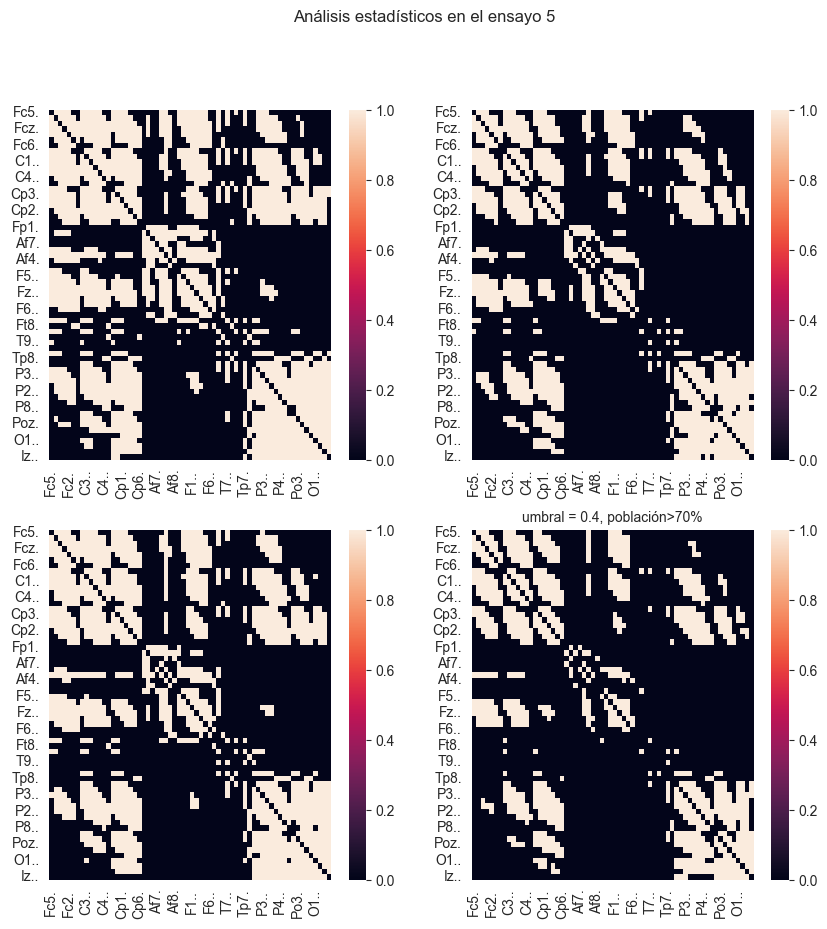

In [96]:
resultado5_df1 = capsula(ensayos5_dfs, 0.3, 0.6)
resultado5_df2 = capsula(ensayos5_dfs, 0.4, 0.6)
resultado5_df3 = capsula(ensayos5_dfs, 0.3, 0.7)
resultado5_df4 = capsula(ensayos5_dfs, 0.4, 0.7)

fig, axes = plt.subplots(2,2, figsize = (10, 10))

sns.heatmap(resultado5_df1, ax=axes[0, 0])
sns.heatmap(resultado5_df2, ax=axes[0, 1])
sns.heatmap(resultado5_df3, ax=axes[1, 0])
sns.heatmap(resultado5_df4, ax=axes[1, 1])
axes[1,1].set_title("umbral = 0.4, población>70%", fontsize = 10)
fig.suptitle('Análisis estadísticos en el ensayo 5')

Text(0.5, 0.98, 'Análisis estadísticos en el ensayo 6')

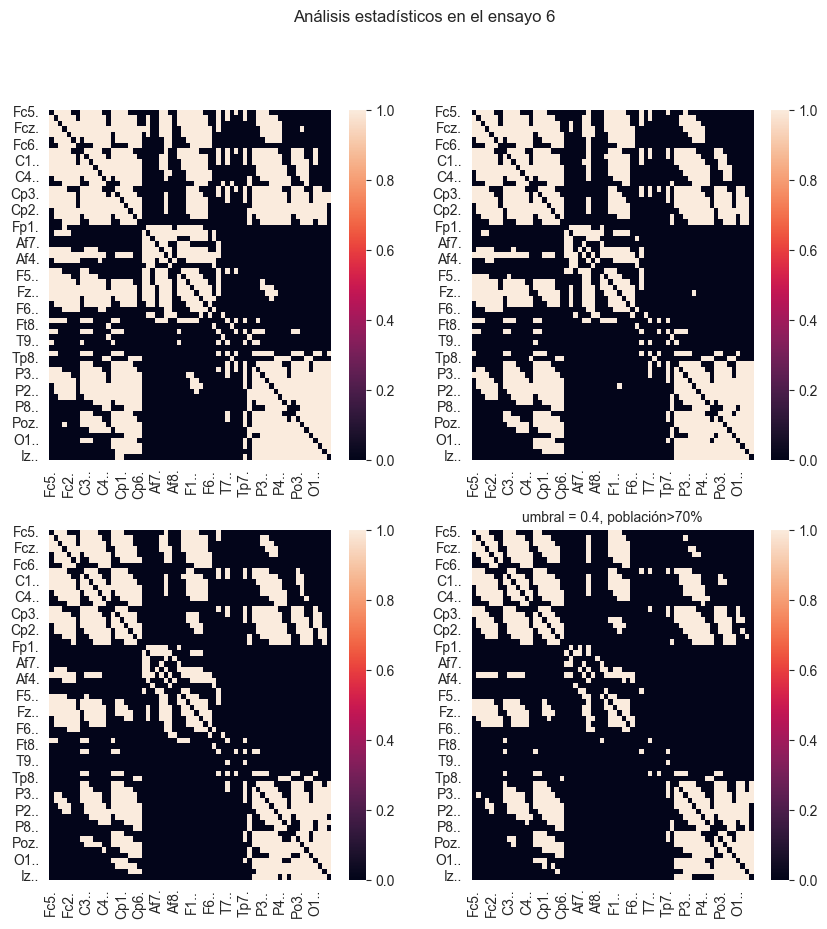

In [97]:
resultado6_df1 = capsula(ensayos6_dfs, 0.3, 0.6)
resultado6_df2 = capsula(ensayos6_dfs, 0.3, 0.7)
resultado6_df3 = capsula(ensayos6_dfs, 0.4, 0.6)
resultado6_df4 = capsula(ensayos6_dfs, 0.4, 0.7)

fig, axes = plt.subplots(2,2, figsize = (10, 10))

sns.heatmap(resultado6_df1, ax=axes[0, 0])
sns.heatmap(resultado6_df2, ax=axes[0, 1])
sns.heatmap(resultado6_df3, ax=axes[1, 0])
sns.heatmap(resultado6_df4, ax=axes[1, 1])
axes[1,1].set_title("umbral = 0.4, población>70%", fontsize = 10)
fig.suptitle('Análisis estadísticos en el ensayo 6')

### Resultados

In [98]:
ensayo5_grafo_ = nx.from_pandas_adjacency(resultado5_df3)
ensayo6_grafo_ = nx.from_pandas_adjacency(resultado6_df1)

In [99]:
(clust_coeff_5, path_length_5, small_world_sigma_5, communities_5,
 modularity_5, betwenness_5, global_eff_5, local_eff_5, degree_dict_5) = metricas_grafo(ensayo5_grafo_)

(clust_coeff_6, path_length_6, small_world_sigma_6, communities_6,
 modularity_6, betwenness_6, global_eff_6, local_eff_6, degree_dict_6) = metricas_grafo(ensayo6_grafo_)

Text(0.5, 0.92, 'Hub del ensayo 5')

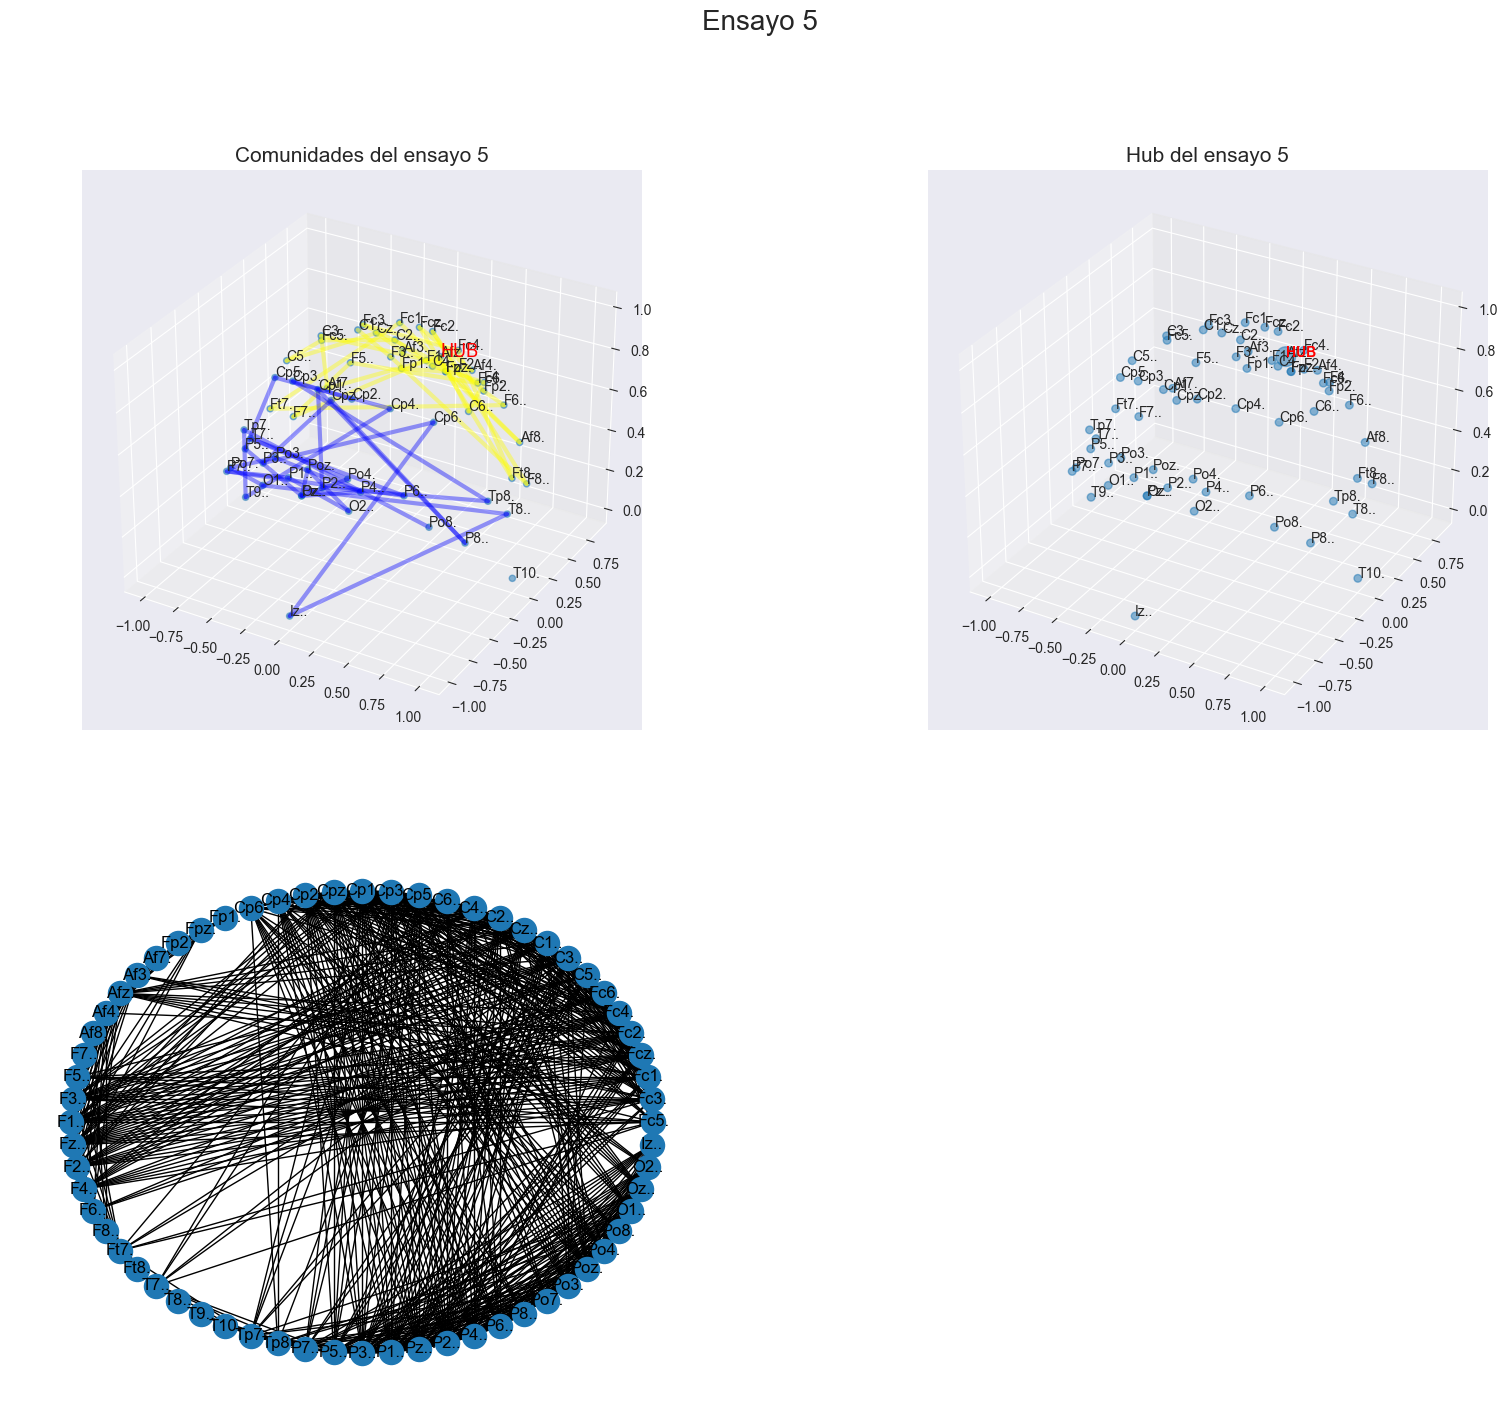

In [114]:
hub = betwenness_5[0]

fig = plt.figure(figsize=(20, 16))
axes = [fig.add_subplot(2, 2, 1, projection='3d'),
        fig.add_subplot(2, 2, 2, projection='3d'),
        fig.add_subplot(2, 2, 3)]

grafo_comunidades(communities_5, hub, myCoor, axes[0])
grafo3D(myCoor, hub, axes[1])
ensayo_grafo = grafo2D(resultado5_df2, axes[2])
fig.suptitle('Ensayo 5', fontsize = 20)
axes[0].set_title('Comunidades del ensayo 5',fontsize=15 )
axes[1].set_title('Hub del ensayo 5', fontsize=15 )

Text(0.5, 0.92, 'Hub del ensayo 6')

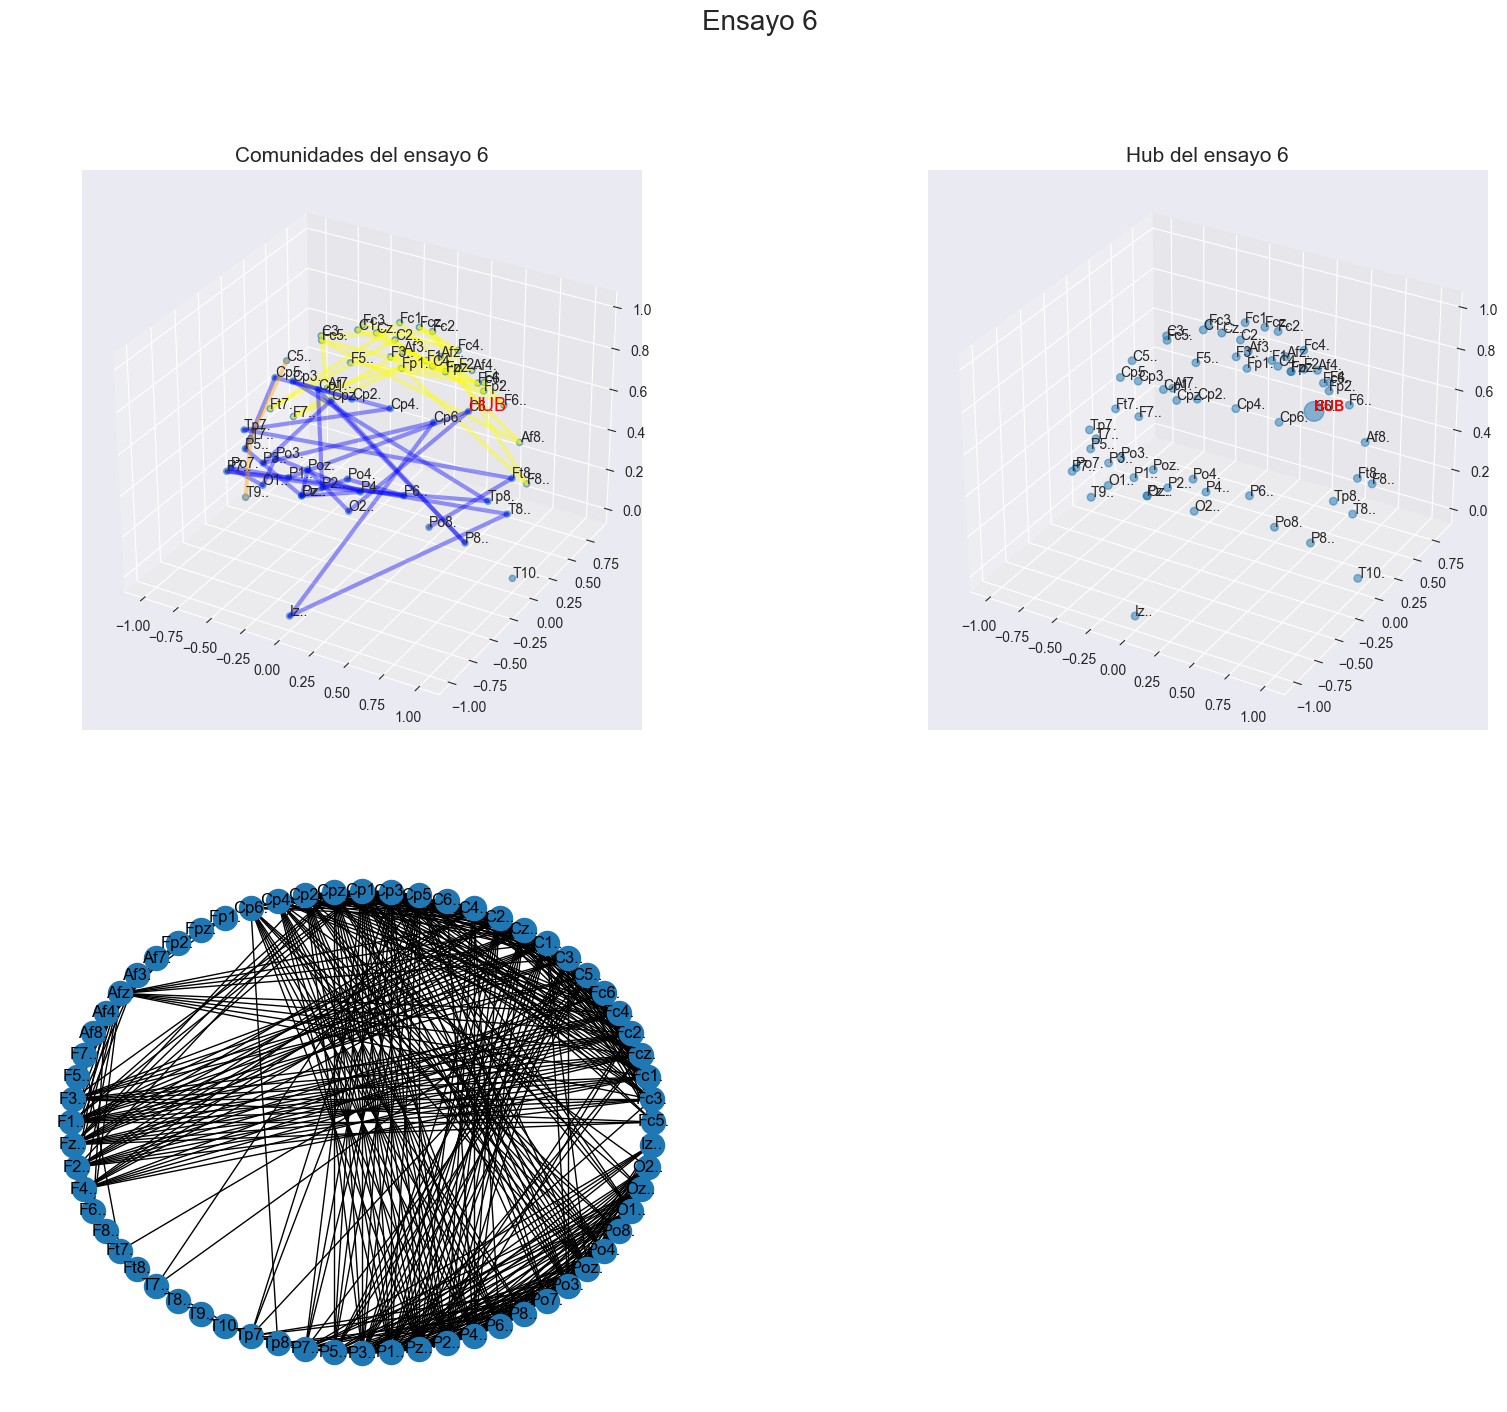

In [115]:
hub = betwenness_6[0]

fig = plt.figure(figsize=(20, 16))
axes = [fig.add_subplot(2, 2, 1, projection='3d'),
        fig.add_subplot(2, 2, 2, projection='3d'),
        fig.add_subplot(2, 2, 3)]

grafo_comunidades(communities_6, hub, myCoor, axes[0])
grafo3D(myCoor, hub, axes[1])
ensayo_grafo = grafo2D(resultado6_df4, axes[2])

fig.suptitle('Ensayo 6', fontsize = 20)
axes[0].set_title('Comunidades del ensayo 6',fontsize=15 )
axes[1].set_title('Hub del ensayo 6', fontsize=15 )

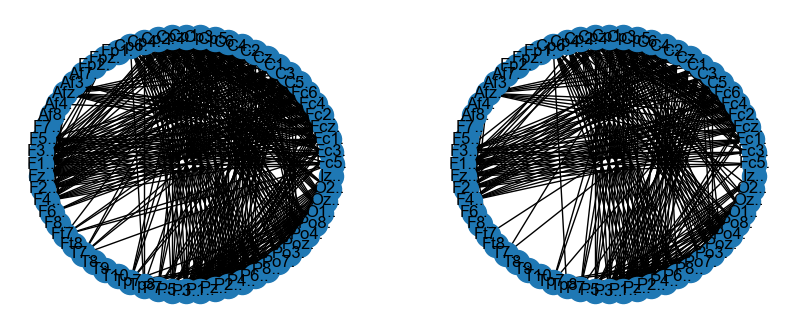

In [103]:
hub5 = betwenness_5[0]
hub6 = betwenness_6[0]

fig = plt.figure(figsize=(10, 4))
axes = [fig.add_subplot(1, 2, 1),
        fig.add_subplot(1, 2, 2)]

ensayo_grafo = grafo2D(resultado5_df2, axes[0])
ensayo_grafo = grafo2D(resultado6_df4, axes[1])

Text(0.5, 0.92, 'Ensayo 6')

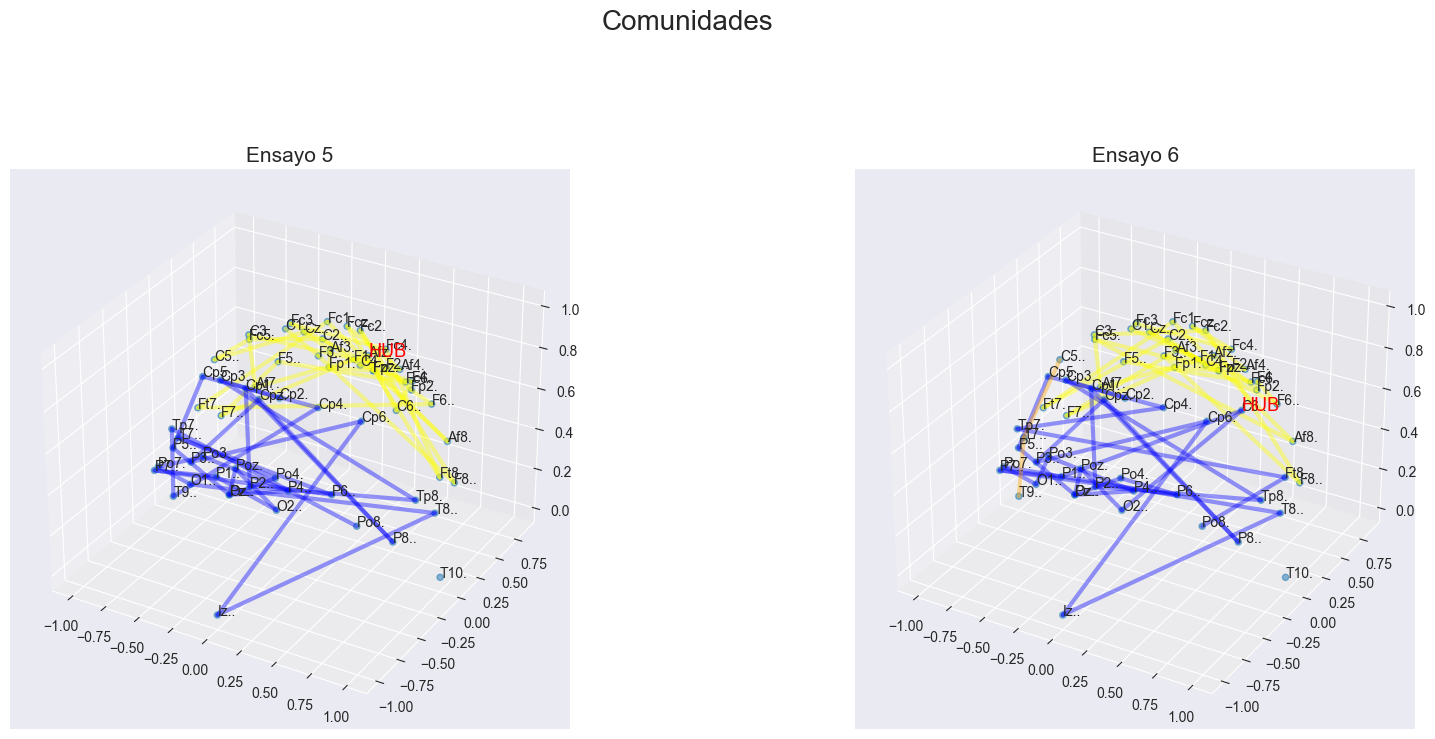

In [116]:
# Comunidades
fig = plt.figure(figsize=(20, 16))
axes = [fig.add_subplot(2, 2, 1, projection='3d'),
        fig.add_subplot(2, 2, 2, projection='3d')]

grafo_comunidades(communities_5, hub5, myCoor, axes[0])
grafo_comunidades(communities_6, hub6, myCoor, axes[1])

fig.suptitle('Comunidades', fontsize = 20)
axes[0].set_title('Ensayo 5',fontsize=15 )
axes[1].set_title('Ensayo 6', fontsize=15 )

In [117]:
hub5

('Afz.', 0.07373119766023696)

In [120]:
hub6

('C6..', 0.05121938306773505)

## Conclusiones

La tarea analizada consistia en abrir para posteriormente cerrar ambos manos o pies dependiendo de si el estimulo visual aparecia en la parte superior o inferior, respectivamente o simplemente imaginar la acción.

En base a los grafos resultantes, se puede observar que en la tarea donde solo tenian que imaginar la acción hay una comunidad extra en comparación donde si realizaban el abrir y cerrar pies/manos, esta comunidad se ven implicados electrodos de lobulos temporales (t7 -sobre giro temporal, principales funciones son lenguaje, audición y procesamiento semantico(Koessler (2009)- y t9-implicado en reconocimiento de objetos-), y coronales (C5 -sobre cx. sensoriomotor, con funciones de movimiento e imaginación motora(Neuper(2006))-), y estos se han visto implicados en tareas en tareas de reconocimientos de objetos y categorías visuales complejas.

Tambien se ve una diferencia en el hub, ya que en aquellos ensayos donde si se llevo a cabo la tarea el hub es **'Afz',** electrodo que se encuentra en la linea media de la cabeza que une a nasion con inion, recibiendo **_información de la corteza frontal medial_**. Esto tiene sentido ya que esta corteza se ve especialmente envuelta en **_toma de desiciones y funciones ejecutivas_**.

En contraste con la tarea de imaginación que el hub es **C6**, sobre la cisura de Rolando derecha, registrando cuando el sujeto mueve o **_imagina mover la mano izquierda_**(varios trabajos de Pfurtscheller y Lopes da Silva lo han medido:))

En conclusión, se pueden ver grafos que reflejan evidencia solida que coincide con lo reportado en la literatura cientifica ya existente, indicandonos que los analisis realizados son correctos :)

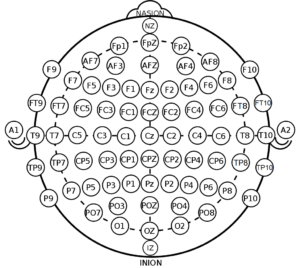